In [90]:
# IMPORT AND PROCESS
import numpy as np
import pandas as pd

from arch import arch_model

# CREATES DATAFRAME FROM BACEN-SGS SERIES
def bacen_sgs_api(names = list(), # names to be assign to series
                  numbers = list(), # series' numbers on SGS
                  initial_date = str(),
                  final_date = str()):
    for i in range(len(names)):
        name = str(names[i])
        url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=csv&&dataInicial={}&dataFinal={}'.format(numbers[i], initial_date, final_date)
        df = pd.read_csv(url, sep = ';', index_col = 0, parse_dates = [0], infer_datetime_format = True, decimal = ',')
        if i == 0:
            DF = pd.DataFrame({name: df.valor},
                              index = df.index)
        else:
            DF[name] = df.valor
    return(DF)

# APPENDS EXCHANGE COUPON TO DATAFRAME
def exchange_coupon(df = pd.DataFrame(), # DataFrame containing the Series for the exchange coupon
                  dol = int(), # column number of exchange rate Series
                  rs = list(), # columns numbers for interest rates Series (min 1 number, if > 1 then more than one measure of exchange coupon is generated)
                  names = list()): # names for exchange coupons
    usd = df[df.columns[dol]]
    for e in range(len(rs)):
        r = df[df.columns[rs[e]]]
        name = names[e]
        arr = np.array(list())
        for i in range(len(usd)):
            if i == 0:
                arr = np.append(arr, np.NaN)
            else:
                arr = np.append(arr, (1+ r[i]/100)/(usd[i]/usd[i-1]))
        df[name] = arr

# APPENDS GARCH'S CSD AND RESIDUALS TO DATAFRAME
def garch(df = pd.DataFrame(), # DataFrame containing the Series 
          cols = list()): # columns numbers of Series
    for i in range(len(cols)):
        name = df.columns[cols[i]]
        fitted_model = arch_model(df[name][1:]).fit()
        df['{}Csd'.format(name)] = fitted_model.conditional_volatility
        df['{}Res'.format(name)] = fitted_model.resid

# APPENDS PARAMETRIC AND NON PARAMETRIC LIMITS TO DATAFRAME
from scipy import stats
def limits(df = pd.DataFrame(), # DataFrame containing the Series
           cols = list()): # columns numbers of Series
    
    # RETURNS ARRAY OF PARAMETRIC LIMIT (UPPER OR LOWER)
    def create_par(up = True):
        mean = series.mean()
        std = series.std()
        if up == True:
            value = mean + stats.norm.ppf(q = 0.975) * (std)
        else:
            value = mean - stats.norm.ppf(q = 0.975) * (std)
        arr = np.array(list())
        for i in range(len(series)):
            if i == 0:
                arr = np.append(arr, np.NaN)
            else:
                arr = np.append(arr, value)
        return(arr)
    # RETURNS ARRAY OF NON PARAMETRIC LIMIT (UPPER OR LOWER)
    def create_non(up = True):
        mean = series.rolling(window = 63, min_periods = 0, center = True).mean()
        std = series.rolling(window = 63, min_periods = 0, center = True).std()
        arr = np.array(list())
        for i in range(len(mean)):
            if up == True:
                value = mean[i] + stats.norm.ppf(q = 0.975) * (std[i])
            else:
                value = mean[i] - stats.norm.ppf(q = 0.975) * (std[i])
            if i == 0:
                arr = np.append(arr, np.NaN)
            else:
                arr = np.append(arr, value)
        return(arr)
    
    for e in range(len(cols)):
        name = df.columns[cols[e]]
        series = df[name]
        # PARAMETRIC
        # ----UPPER
        df['{}ParUp'.format(name)] = create_par(up=True)
        # ----LOWER 
        df['{}ParLo'.format(name)] = create_par(up=False)
        # NON PARAMETRIC
        # ----UPPER
        df['{}NonUp'.format(name)] = create_non(up = True)
        # ----LOWER
        df['{}NonLo'.format(name)] = create_non(up = False)

In [91]:
# OUTPUT OF GRAPHS
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import statsmodels.tsa.stattools as stat

# GRAPH FOR ONE OR MULTIPLE SERIES
def graph(series = list(), # list with Series to be plotted
          legends = list(), # legends for Series. if empty, legends are not included
          y_axis = str(), # name of y axis
          title = str(), # title of graphic in LaTeX
          label = str()): # label to use in LaTeX
    for serie in series:
        ax = serie.plot(figsize = (8,5))
    if len(legends) > 0:
        ax.legend(legends)
    ax.grid(axis = 'x')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gcf().autofmt_xdate()
    plt.xlabel('Date')
    plt.ylabel(y_axis)
    plt.savefig('graphs/{}'.format(label), dpi = 200)
    plt.show()

    a = open('graphstext/{}.txt'.format(label), 'w')
    a.write('''\\begin{{figure}}[H]
\\caption{{{0}}}
\\label{{fig:{1}}}
\\centering
\\includegraphics[width=\\textwidth]{{graphs/{1}.png}}
\\end{{figure}}'''.format(title, label))
    a.close()

# GRAPH FOR ACF ND PACF
def acf_pacf(serie, # Series
             graphName,
             refName, 
             pacf = False): # IF FALSE, RETURNS ONLY ACF GRAPH
    cima = []
    baixo = []
    for i in stat.acf(serie[1:], alpha = .05)[1]:
        cima.append(i[0])
        baixo.append(i[1])
    va = {'cima': cima, 'baixo': baixo}
    a = pd.DataFrame(va)

    serieum = pd.Series(stat.acf(serie[1:], alpha = .05)[0])
    serieum.plot(figsize = (8,5), kind = 'bar')
    plt.plot(a)
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.legend(('97.5%', '2.5%'))
    plt.savefig('graphs/{}acf'.format(refName))
    plt.show()

    if pacf == True:
        cima = []
        baixo = []
        for i in stat.pacf(serie[1:], alpha = .05)[1]:
            cima.append(i[0])
            baixo.append(i[1])
        va = {'cima': cima, 'baixo': baixo}
        a = pd.DataFrame(va)

        serieum = pd.Series(stat.pacf(serie[1:], alpha = .05)[0])
        serieum.plot(figsize = (8,5), kind = 'bar')
        plt.plot(a)
        plt.xlabel('Lag')
        plt.ylabel('PACF')
        plt.legend(('97.5%', '2.5%'))
        plt.savefig('graphs/{}pacf'.format(refName))
        plt.show()
    
    a = open('graphstext/{}acf.txt'.format(refName), 'w')
    a.write('''\\begin{{figure}}[H]
\\caption{{Auto-Correlation Funcion for {0}}}
\\label{{fig:{1}acf}}
\\centering
\\includegraphics[width=\\textwidth]{{graphs/{1}acf.png}}
\\end{{figure}}'''.format(graphName, refName))
    a.close() 

    if pacf == True:
        a = open('graphstext/{}pacf.txt'.format(refName), 'w')
        a.write('''\\begin{{figure}}[H]
\\caption{{Partial Auto-Correlation Funcion for {0}}}
\\label{{fig:{1}pacf}}
\\centering
\\includegraphics[width=\\textwidth]{{graphs/{1}pacf.png}}
\\end{{figure}}'''.format(graphName, refName))
        a.close() 

In [92]:
BASE = bacen_sgs_api(names = ['Ptax', 'Selic', 'Di'],
                     numbers = [1, 11, 12],
                     initial_date = '26/09/2016',
                     final_date = '16/05/2019')

exchange_coupon(BASE, 0, [1, 2], ['Oc1', 'Di1'])

garch(BASE, [3,4])

limits(BASE, [5, 7])

BASE.head()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2235.5343356404182
Iteration:      2,   Func. Count:     19,   Neg. LLF: -2235.592112061573
Iteration:      3,   Func. Count:     29,   Neg. LLF: -2235.5981186195077
Iteration:      4,   Func. Count:     39,   Neg. LLF: -2235.6030963646144
Iteration:      5,   Func. Count:     47,   Neg. LLF: -2235.7761831536664
Iteration:      6,   Func. Count:     55,   Neg. LLF: -2235.823254206839
Iteration:      7,   Func. Count:     64,   Neg. LLF: -2235.823465004779
Iteration:      8,   Func. Count:     72,   Neg. LLF: -2235.829165044097
Iteration:      9,   Func. Count:     79,   Neg. LLF: -2235.838108599886
Iteration:     10,   Func. Count:     86,   Neg. LLF: -2235.8382049140346
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2235.8382049109855
            Iterations: 10
            Function evaluations: 97
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF:

,Ptax,Selic,Di,Oc1,Di1,Oc1Csd,Oc1Res,Di1Csd,Di1Res,Oc1CsdParUp,Oc1CsdParLo,Oc1CsdNonUp,Oc1CsdNonLo,Di1CsdParUp,Di1CsdParLo,Di1CsdNonUp,Di1CsdNonLo
data,,,,,,,,,,,,,,,,,
2016-09-26,3.2400,0.052531,0.052461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-27,3.2358,0.052531,0.052461,1.001824,1.001823,0.007428,0.001896,0.007430,0.001893,0.011341,0.005048,0.009398,0.006160,0.011344,0.005042,0.009404,0.006154
2016-09-28,3.2476,0.052531,0.052461,0.996890,0.996889,0.007287,-0.003038,0.007287,-0.003041,0.011341,0.005048,0.011418,0.004669,0.011344,0.005042,0.011430,0.004658
2016-09-29,3.2235,0.052531,0.052461,1.008006,1.008005,0.007255,0.008077,0.007255,0.008075,0.011341,0.005048,0.011961,0.004435,0.011344,0.005042,0.011971,0.004426
2016-09-30,3.2462,0.052531,0.052461,0.993529,0.993528,0.007721,-0.006400,0.007723,-0.006402,0.011341,0.005048,0.012150,0.004430,0.011344,0.005042,0.012159,0.004423


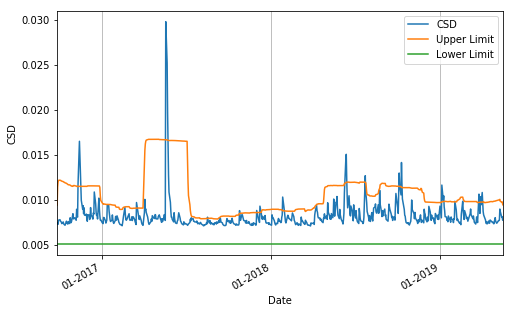

In [116]:
graph([BASE.Oc1Csd, BASE.Oc1CsdNonUp, BASE.Oc1CsdParLo],
      ['CSD', 'Upper Limit', 'Lower Limit'],
      'CSD', 'asdfaf', 'asdf')

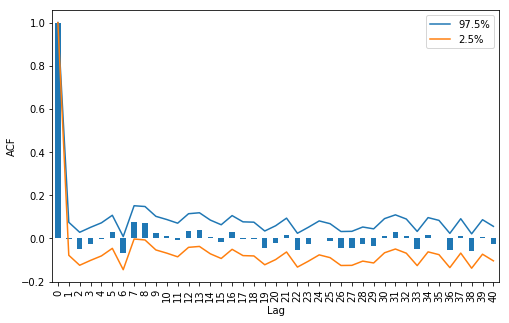

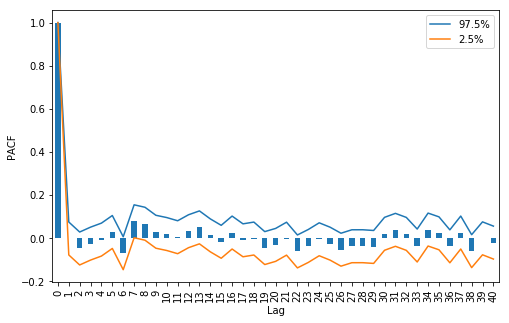

In [117]:
acf_pacf(BASE.Oc1, 'asdf', 'asdf', pacf = True)